In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import math
import pywt
import scipy
from scipy import ndimage
from sklearn.metrics import silhouette_score, calinski_harabaz_score
import matplotlib.colors as color

In [2]:
#Change viewing options
from IPython.core.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

In [3]:
#from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
#client

In [4]:
#Bring in the whole dataset
start = time.time()
ds = xr.open_mfdataset('/Users/ddesantis/Downloads/livneh_NAmerExt_15Oct2014.*.mon.nc', autoclose=True)
end = time.time()
print(end - start)

12.020731926


# Define functions in package:

## Filtering Functions

In [5]:
def filter_out_nan(shaped):
    '''This function filters out nan values from a matrix nxm, and saves the index for threading back together'''
    data = []
    index = []
    index_nan = []
    count = 0
    for p in range(shaped.shape[0]):
        if np.isnan(shaped[p][0]):  #check if nan
            index_nan.append(count)
            count = count +1
        else:
            data.append(shaped[p])
            index.append(count)
            count = count + 1    
            
    data = da.stack(data, axis=0)
    return data, index, index_nan

In [6]:
def filter_in_nan(classes, index, index_nan):
    '''The inverse function of filter_out_nan - used to put nan values back into set after clustering'''
    classes_nan = np.ones(len(index_nan))*np.nan
    classes = np.append(classes, classes_nan)


    index_all = index + index_nan
    index_all = np.array(index_all)

    classes = classes[np.argsort(index_all)]
    
    return classes

In [7]:
def build_masks(data, iterations=2):
    '''
    Given a data cube, construct all the different nan_masks needed for clustering
    '''
    #First, get cube of nan_mask
    nan_mask_cube = np.isnan(data)
    nan_mask_cube = np.array(nan_mask_cube)
    nan_mask_cube = nan_mask_cube*np.array(data)
    
    #Get a single slice of nan_mask
    nan_mask_slice = nan_mask_cube[0]
    
    #Erode nan values for difference in clustering
    nan_mask_er = scipy.ndimage.morphology.binary_erosion(nan_mask_slice, iterations= iterations).astype(nan_mask_slice.dtype)
    
    #Build cube of erroded nan_mask:
    nan_mask_er_cube = np.tile(nan_mask_er, (data.shape[0],1,1))
    nan_mask_er_cube[nan_mask_er_cube ==1] = np.nan
    
    return nan_mask_cube, nan_mask_slice, nan_mask_er_cube

## DWT Functions

In [8]:
def wavelet_levels(data_set, level_time, level_space, wavelet_time, wavelet_space):
    '''
    The following code computes the DWT in space-time.  The space is computed using the wavelet_space, time is wavelet_time.  The level of the transformation for space and time are 
    level_space and level_time respectively. The data for LOCA has space as [1,2].
    '''
    
    wp = pywt.wavedecn(data=data_set, wavelet = wavelet_space, level = level_space, axes = [1,2])
    wp = pywt.wavedecn(data=wp[0], wavelet = wavelet_time, level = level_time, axes = [0])
    
    return wp

## Filtering and K-means

In [795]:
def filter_kmeans(dwt_data, dwt_nan, n_clusters):
    '''
    This function combines the dwt's to result in dwt of data + epsilon boundary.  We then cluster on the non-nan values of this result.  The final classes are relaced with the nan-values.
    '''
    
    #Combine the DWT of each:
    data = dwt_data[0] + dwt_nan[0]  #the zero is to select the approximation coeff.
    
    #Reshape the data:
    shaped = np.reshape(data, (data.shape[0], data.shape[1]*data.shape[2]))
    shaped = shaped.T
    
    #Filter out nan values
    start = time.time()
    data_t, index_t, index_nan_t = filter_out_nan(shaped)
    end = time.time()
    print("Filter out: " + str(end - start))
    
    #K-means the result
    start=time.time()
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_t)
    classes = kmeans.labels_
    end = time.time()
    print("Clustering: " + str(end - start))
    
    #Filter back in the nan values
    classes = filter_in_nan(classes, index_t, index_nan_t)
    
    #Reshape
    classes = np.reshape(classes, (data.shape[1],data.shape[2]))
    
    return classes

In [10]:
def order_class(classes, centers):
    '''
    Takes the classes from kmeans and reorders according to the norm of the cluster centers
    '''
    #find norm of each cluster and sort
    order = np.argsort(np.linalg.norm(centers, axis=1))
    #sort the class array by order
    classes = order[classes]

    return classes

## Index maps to return labels from clustering on DWT to initial data

In [11]:
#First, dwt_length is run to compute the length of each wavelet transform level.  This information is used to build the functions that will map the index up one level in the DWT (map_back_index)

In [12]:
def dwt_length(data, wavelet):
    '''
    Record the lengths of the data at each wavelet transform.  This function is run outside map_back_classes
    '''
    dwt_lengths = [data.size]
    max_level = pywt.dwt_max_level(data_len = data.size, filter_len = pywt.Wavelet(wavelet).dec_len)
    
    for i in range(max_level):
        l = pywt.dwt_coeff_len(dwt_lengths[i], pywt.Wavelet(wavelet).dec_len, mode='symmetric')
        dwt_lengths.append(l)
    
    return dwt_lengths

In [13]:
def middle_match(data_len,wavelet):
    '''
    Build the middle part of the filter matrix
    '''
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len
    
    #Build the first row of the matrix
    I_m = np.zeros(data_len)
    I_m[:w_len] = w_fil
    
    #Make the shift matrix
    row_number = int(np.ceil((float(data_len)-w_len)/2))
    
    if data_len%2 == 0:
        for j in range(1, row_number+1):
            row = np.zeros(data_len)
            row[2*j:w_len + 2*j]= w_fil
            I_m = np.concatenate((I_m,row), axis=0)
    
        I_m = np.reshape(I_m, (row_number+1,data_len))
    else:
        for j in range(1, row_number):
            row = np.zeros(data_len)
            row[2*j:w_len + 2*j]= w_fil
            I_m = np.concatenate((I_m,row), axis=0)
    
        I_m = np.reshape(I_m, (row_number,data_len))        
        
        
    return I_m

In [14]:
def top_match(data_len, wavelet):
    '''
    Build the top part of the filter matrix
    '''    
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len
    
    #Build blank matrix
    row_number = int(np.ceil((w_len)/2))
    
    I_t = np.zeros((row_number-1,data_len))
    
    #Make the shift matrix
    for j in range(1,row_number):
        overflow = w_fil[:2*j]
        overflow = np.flip(overflow, axis=0)
        row_o = np.zeros(data_len)
        row_o[:2*j] = overflow
        
        leftover = w_fil[2*j:]
        row_l = np.zeros(data_len)
        row_l[:leftover.size] = leftover
        
        row = row_o + row_l      
        
        I_t[j-1] = row
    
    return I_t

In [15]:
def bot_match(data_len, wavelet):
    '''
    Build the bottom part of the filter matrix
    '''   
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len

    row_number = int(np.ceil((w_len)/2))
    
    
    if data_len%2 ==0:
        I_b = np.zeros((row_number-1,data_len))
        for j in range(1,row_number):
            overflow = w_fil[-2*j:]
            overflow = np.flip(overflow, axis=0)
            row_o = np.zeros(data_len)
            row_o[-2*j:] = overflow
            
            
            leftover = w_fil[:-2*j]
            row_l = np.zeros(data_len)
            row_l[-leftover.size:] = leftover
            
            row = row_o + row_l
            
            I_b[j-1] = row         
    else:
        I_b = np.zeros((row_number,data_len))
        for j in range(1,row_number+1):         
            overflow = w_fil[-2*j+1:]
            overflow = np.flip(overflow, axis=0)
            row_o = np.zeros(data_len)
            row_o[-2*j+1:] = overflow
            
            leftover = w_fil[:-2*j+1]
            row_l = np.zeros(data_len)
            row_l[-leftover.size:] = leftover

            
            row = row_o + row_l
            
            I_b[j-1] = row
            
    return I_b

In [16]:
def filter_matrix(data_len, wavelet):
    '''
    Function used to build filter matrix for mapping classes back one level
    '''
    
    I_m = middle_match(data_len, wavelet)
    I_t = top_match(data_len, wavelet)
    I_b = bot_match(data_len, wavelet)
    
    I = np.concatenate((I_t,I_m), axis=0)
    I = np.concatenate((I,I_b), axis=0)
    
    return I

In [17]:
def map_back_index(wavelet, dwt_lengths, max_level):
    '''
    Function used to discover classes at one stage higher resolution
    '''
    
    index_up=[]
    
    for j in range(max_level):
        I = filter_matrix(dwt_lengths[j], wavelet)
        I = np.abs(I)
        classes_index = np.argmax(I,axis=0)
        index_up.append(classes_index)
        
    return index_up

In [18]:
def map_back_classes(MR_clusters, index_up_lat, index_up_lon, level_time_lo, level_time_hi, level_space_lo, level_space_hi):
    """
    Function used to map the MR clusters back to the initial data points
    """
    final_class = {}
    for i in range(level_space_lo, level_space_hi+1):
        for j in range(level_time_lo, level_time_hi+1):
            temp = MR_clusters[i,j]
            for k in range(1,i+1):
                temp = temp[index_up_lat[i-k]][:,index_up_lon[i-k]]
            final_class[i,j] = temp
    
    return final_class

## Combine Classes

In [845]:
def produce_labels(stacked):
    '''
    Create a lex index for each possible clustering array (skipping nan)
    '''
    index = 0
    labels = {}
    for col in range(stacked.shape[1]):
            labels[stacked[:,col].tobytes()] = index
            index = index+ 1
                
    return labels

In [904]:
def thresh_lex(lexlabels, nan_mask_slice, percent=0.002):
    lexlabels_thresh = lexlabels
    #Replace the numbers that appear from lex labels with smallest possible counting set
    count = 0
    for number in np.unique(lexlabels_thresh):
        lexlabels_thresh[lexlabels_thresh==number] = count
        count = count+1
        
    #Set delete class if too small based of percent:
    thresh = np.count_nonzero(~np.isnan(nan_mask_slice))*percent
    
    number_labels = np.unique(lexlabels_thresh).size
    
    #We will delete class corresponding to the nan, and put all the small classes together.
    #First, remove the class where nans are:
    #Shift all the index up by 2 to make room:
    lexlabels_thresh = lexlabels_thresh +2
    
    #Find out where the nan values are, and set them to zero
    masking = np.nan_to_num(nan_mask_slice+1)
    lexlabels_thresh = masking*lexlabels_thresh
    
    #Remove classes with a small number of points to unclassified.  These are set to class 1
    for i in range(number_labels):
        if np.count_nonzero(lexlabels_thresh==i) <thresh:
            ind = np.argwhere(lexlabels_thresh==i)
            for [a,b] in ind:
                lexlabels_thresh[a,b] = 1    
    
    #Recount again with removed labels.  This sets the nan class to -1, and removed class to 0:
    count = -1
    for number in np.unique(lexlabels_thresh):
        lexlabels_thresh[lexlabels_thresh==number] = count
        count = count+1
        
    #number_labels_thresh = np.max(lexlabels_thresh)
    #number_labels_thresh
    
    #Add nan mask
    #lexlabels_thresh = lexlabels_thresh + nan_mask_slice
    
    return lexlabels_thresh

In [905]:
def combine_classes(stacked, nan_mask_slice, percent=0.002):
    #Produce labels
    labels = produce_labels(stacked)
    
    #Convert the array of k-values at each point into lex labels
    lexlabels = []
    for col in range(stacked.shape[1]):
            lexlabels.append(labels[stacked[:,col].tobytes()])
    
    lexlabels = np.array(lexlabels)
    lexlabels = np.reshape(lexlabels,(ds2.lat.size,ds2.lon.size))
    
    #Threshold the labels
    lexlabels_thresh = thresh_lex(lexlabels, nan_mask_slice, percent)
    
    return lexlabels_thresh

In [906]:
stacked_t = np.stack((Prec_classes[(1,0)], Tmax_classes[(1,0)], Tmin_classes[(1,0)]))
stacked_t = stacked_t.reshape((3,ds2.lat.size*ds2.lon.size))

In [907]:
lexlabels_thresh_t = combine_classes(stacked_t, nan_mask_slice)

In [908]:
lexlabels_thresh_t.shape

(614, 928)

In [909]:
np.unique(lexlabels_thresh_t)

array([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

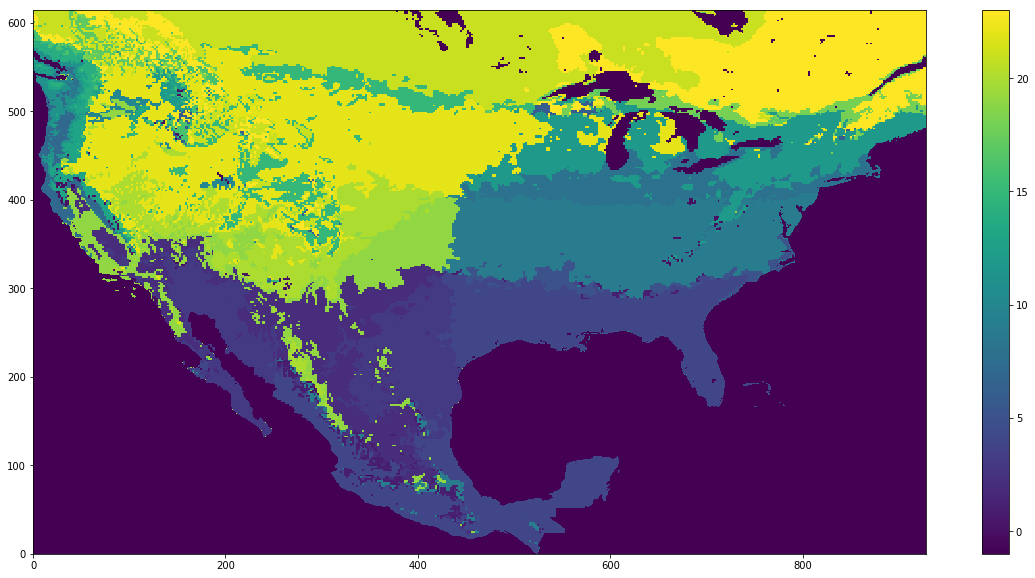

In [910]:
plt.figure(figsize=(20,10))
p0 = plt.pcolormesh(lexlabels_thresh_t)
plt.colorbar(p0)
plt.show()

# Main Function

In [800]:
def MR_sets(data_set, nan_mask_er_cube, level_time_lo, level_time_hi, level_space_lo, level_space_hi, wavelet_time = 'haar', wavelet_space='haar', n_clusters = 3):
    """
    Compute the DWT of interest and cluster
    """
    startt=time.time()
    
    print("Level Space: " + str(level_space_lo))
    print("Level Time: " + str(level_time_lo))   
    
    #Initial DWT's
    start = time.time()
    wp = wavelet_levels(data_set, level_time_lo, level_space_lo, wavelet_time, wavelet_space)
    dwt_nan = wavelet_levels(nan_mask_er_cube, level_time_lo, level_space_lo, wavelet_time, wavelet_space)
    end=time.time()
    diff = str(end-start)
    print("DWT: " + diff)
    
    #Find classes (classes shaped with nans added back):
    start=time.time()
    classes = filter_kmeans(wp,dwt_nan, n_clusters)
    end = time.time()
    diff = str(end-start)
    print("Clustering: " + diff)
    
    #Save the cluster
    MR_clusters = {(level_space_lo,level_time_lo): classes}
    
    print("")
    #The time DWT for first spatial level
    
    #Create a temp list to use for time DWTs
    wp_t = list(wp)
    dwt_nan_t = list(dwt_nan)
    for j in range(level_time_lo+1, level_time_hi+1):
        #Time DWT:
        print("Level Space: " + str(level_space_lo))
        print("Level Time: " + str(j)) 
        start = time.time()
        wp_t = wavelet_levels(wp_t[0], level_time = 1, level_space = 0, wavelet_time = wavelet_time, wavelet_space = wavelet_space)
        dwt_nan_t = wavelet_levels(dwt_nan_t[0], level_time = 1, level_space = 0, wavelet_time = wavelet_time, wavelet_space = wavelet_space) #Can probably remove this...times don't change
        end=time.time()
        diff = str(end-start)
        print("DWT: " + diff)
            
        #Find classes (classes shaped with nans added back):
        start=time.time()
        classes = filter_kmeans(wp_t,dwt_nan_t, n_clusters)
        end = time.time()
        diff = str(end-start)
        print("Clustering: " + diff)
    
        #Save the cluster
        MR_clusters = {(level_space_lo,level_time_lo): classes}
        
        print("")
    
    
    #Increment the dwt levels and cluster
    for i in range(level_space_lo+1,level_space_hi+1):
        #Space DWT:
        print("Level Space: " + str(i))
        print("Level Time: " + str(level_time_lo)) 
        start = time.time()
        wp = wavelet_levels(wp[0], level_time = 0, level_space = 1, wavelet_time = wavelet_time, wavelet_space = wavelet_space)
        dwt_nan = wavelet_levels(dwt_nan[0], level_time_lo, level_space_lo, wavelet_time, wavelet_space)
        end=time.time()
        diff = str(end-start)
        print("DWT: " + diff)
        
        #Find classes (classes shaped with nans added back):
        start=time.time()
        classes = filter_kmeans(wp,dwt_nan, n_clusters)
        end = time.time()
        diff = str(end-start)
        print("Clustering: " + diff)
    
        #Save the cluster
        MR_clusters = {(level_space_lo,level_time_lo): classes}
        
        print("")
        
        #Create a temp list to use for time DWTs
        wp_t = list(wp)
        dwt_nan_t = list(dwt_nan)
        for j in range(level_time_lo+1, level_time_hi+1):
            #Time DWT:
            print("Level Space: " + str(i))
            print("Level Time: " + str(j)) 
            start = time.time()
            wp_t = wavelet_levels(wp_t[0], level_time = 1, level_space = 0, wavelet_time = wavelet_time, wavelet_space = wavelet_space)
            dwt_nan_t = wavelet_levels(dwt_nan_t[0], level_time = 1, level_space = 0, wavelet_time = wavelet_time, wavelet_space = wavelet_space)
            end=time.time()
            diff = str(end-start)
            print("DWT: " + diff)
            
            #Find classes (classes shaped with nans added back):
            start=time.time()
            classes = filter_kmeans(wp,dwt_nan_t, n_clusters)
            end = time.time()
            diff = str(end-start)
            print("Clustering: " + diff)
            
            print("")
            
    endt = time.time()
    difft = str(endt - startt)
    print("TOTAL: " + difft)
    
    return MR_clusters

In [21]:
def prep_data(data, variable, factor_h, factor_v, factor_a):
    '''
    Preps data for clustering by replacing nan values with a linear combination of interpolation in x direction, y direction, and average values
    '''
    #Horizontal interpolation
    start = time.time()
    data_h = data[variable].to_dataframe()
    data_h = data_h.interpolate(limit_direction = 'both')
    data_h = data_h.to_xarray()
    data_h = data_h[variable].data
    print("Horz. Time: " + str(time.time() - start))
    
    #Vertical interpolation
    start = time.time()
    data_v = data[variable].transpose('time','lon','lat')
    data_v = data_v.to_dataframe()
    data_v = data_v.interpolate(limit_direction = 'both')
    data_v = data_v.to_xarray()
    data_v = data_v.transpose('time','lat','lon')
    data_v = data_v[variable].data
    print("Vert. Time: " + str(time.time() - start))
    
    
    #Average value
    start = time.time()    
    mean = np.array(data[variable].mean())
    data_a = da.nan_to_num(data[variable].data)
    data_a[data_a==0] = mean
    data_a = np.array(data_a)
    print("Ave. Time: " + str(time.time() - start))
    #Linear combo
    final = (factor_h*data_h + factor_v*data_v + factor_a*data_a)/(factor_h + factor_v + factor_a)
    
    return final

# Test Algorithm on Data:

## Compute Series of classes

In [940]:
#Set of time slices
t_chunk = 20*12
t_delta = 1*12
steps = (768-t_chunk)/(t_delta)

In [941]:
steps

44

In [932]:
#Time to do a single clustering at this resolution
#(48.6665360928 + 51.7778990269 + 14.1644079685 + 49.4582858086 + 50.814977169 + 13.7983682156 +49.2783031464 + 51.7278950214 +12.460185051 + 127.660867929 + 126.88735199 + 126.408263922)/60

12.051722355686666

In [947]:
#12*44/60

8

In [948]:
Prec_classes_all = {}
Tmax_classes_all = {}
Tmin_classes_all = {}
labels_all = {}

for step in range(steps+1):
    dst = ds.isel(time=slice(t_delta*step,t_chunk+t_delta*step))
    #Set up data:
    
    #Prec data interpolated to remove nan
    data_Prec = prep_data(dst,'Prec',1,1,6)
    #Tmax data interpolated to remove nan
    data_Tmax = prep_data(dst,'Tmax',1,1,6)
    #Tmin data interpolated to remove nan
    data_Tmin = prep_data(dst,'Tmin',1,1,6)
    
    #Set up variables to be used
    #Get Nan_mask
    nan_mask_cube, nan_mask_slice, nan_mask_er_cube = build_masks(ds2.Prec.data, iterations=4)

    #First, the time information:
    wave_time = 'db2'
    max_level_time = pywt.dwt_max_level(data_len = ds2.time.size, filter_len = pywt.Wavelet(wave_time).dec_len) 

    #Next, space information:
    wave_space = 'haar'
    max_level_lat= pywt.dwt_max_level(data_len = ds2.lat.size, filter_len = pywt.Wavelet(wave_space).dec_len) 
    max_level_lon= pywt.dwt_max_level(data_len = ds2.lon.size, filter_len = pywt.Wavelet(wave_space).dec_len) 
    max_level= min(max_level_lat, max_level_lon, max_level_time)

    #In order to invert the DWT classifier, need lengths for lat, lon, time:

    #dwt_lengths_time = dwt_length(ds2.time, wave_time)
    dwt_lengths_lat = dwt_length(ds2.lat, wave_space)
    dwt_lengths_lon = dwt_length(ds2.lon, wave_space)

    #index_up_time = map_back_index(wave_time,dwt_lengths_time,max_level_time)
    index_up_lat = map_back_index(wave_space,dwt_lengths_lat,max_level_lat)
    index_up_lon = map_back_index(wave_space,dwt_lengths_lon,max_level_lon)

    #Set the bounds for space and time levels of DWT
    level_time_lo=0
    level_time_hi=0
    level_space_lo=1
    level_space_hi=1
    
    #Compute Clusters:
    MR_clusters_Prec = MR_sets(data_Prec, nan_mask_er_cube[0:240], level_time_lo, level_time_hi, level_space_lo, level_space_hi, wavelet_space = wave_space, wavelet_time = wave_time, n_clusters = 3)
    Prec_classes = map_back_classes(MR_clusters_Prec, index_up_lat, index_up_lon, level_time_lo, level_time_hi, level_space_lo, level_space_hi)
    MR_clusters_Tmax = MR_sets(data_Tmax, nan_mask_er_cube[0:240], level_time_lo, level_time_hi, level_space_lo, level_space_hi, wavelet_space = wave_space, wavelet_time = wave_time, n_clusters = 4)
    Tmax_classes = map_back_classes(MR_clusters_Tmax, index_up_lat, index_up_lon, level_time_lo, level_time_hi, level_space_lo, level_space_hi)
    MR_clusters_Tmin = MR_sets(data_Tmin, nan_mask_er_cube[0:240], level_time_lo, level_time_hi, level_space_lo, level_space_hi, wavelet_space = wave_space, wavelet_time = wave_time, n_clusters = 4)
    Tmin_classes = map_back_classes(MR_clusters_Tmin, index_up_lat, index_up_lon, level_time_lo, level_time_hi, level_space_lo, level_space_hi)
    
    Prec_classes_all[step] = Prec_classes
    Tmax_classes_all[step] = Tmax_classes
    Tmin_classes_all[step] = Tmin_classes
    
    #Combine clusters:
    
    stacked = np.stack((Prec_classes[(1,0)], Tmax_classes[(1,0)], Tmin_classes[(1,0)]))
    stacked = stacked.reshape((3,ds2.lat.size*ds2.lon.size))
    lexlabels_thresh = combine_classes(stacked, nan_mask_slice)
    
    labels_all[step] = lexlabels_thresh

Horz. Time: 48.5236988068
Vert. Time: 50.3705961704
Ave. Time: 12.5870001316
Horz. Time: 49.6626560688
Vert. Time: 50.3671970367
Ave. Time: 12.8100998402
Horz. Time: 50.0598840714
Vert. Time: 50.4382100105
Ave. Time: 12.7809309959
Level Space: 1
Level Time: 0
DWT: 8.16999197006
Filter out: 17.3267860413
Clustering: 80.0309569836
Clustering: 97.6271829605

TOTAL: 105.798664808
Level Space: 1
Level Time: 0
DWT: 8.1733880043
Filter out: 16.7609059811
Clustering: 80.3408069611
Clustering: 97.3619279861

TOTAL: 105.536197901
Level Space: 1
Level Time: 0
DWT: 8.17406606674
Filter out: 18.433205843
Clustering: 80.3293528557
Clustering: 99.0205020905

TOTAL: 107.195762157
Horz. Time: 48.3657591343
Vert. Time: 50.4340610504
Ave. Time: 14.0631291866
Horz. Time: 49.4660010338
Vert. Time: 50.4730739594
Ave. Time: 11.728374958
Horz. Time: 49.7616610527
Vert. Time: 50.4694941044
Ave. Time: 13.3443319798
Level Space: 1
Level Time: 0
DWT: 8.19187402725
Filter out: 17.1471590996
Clustering: 79.31237483

Ave. Time: 12.9654760361
Horz. Time: 48.9568331242
Vert. Time: 50.3802630901
Ave. Time: 13.2203478813
Level Space: 1
Level Time: 0
DWT: 8.20800495148
Filter out: 16.8257761002
Clustering: 79.7290818691
Clustering: 96.8135268688

TOTAL: 105.023293018
Level Space: 1
Level Time: 0
DWT: 8.15471696854
Filter out: 17.5940191746
Clustering: 79.3520538807
Clustering: 97.2099399567

TOTAL: 105.365684032
Level Space: 1
Level Time: 0
DWT: 8.22249507904
Filter out: 17.1870560646
Clustering: 82.5433630943
Clustering: 99.9810769558

TOTAL: 108.204673052
Horz. Time: 48.3600440025
Vert. Time: 50.3286669254
Ave. Time: 13.3754870892
Horz. Time: 48.4437639713
Vert. Time: 50.6020390987
Ave. Time: 13.4362781048
Horz. Time: 49.5961511135
Vert. Time: 50.2420318127
Ave. Time: 13.235574007
Level Space: 1
Level Time: 0
DWT: 8.17490100861
Filter out: 16.890734911
Clustering: 79.549090147
Clustering: 96.6948180199

TOTAL: 104.871221066
Level Space: 1
Level Time: 0
DWT: 8.18964099884
Filter out: 17.4753599167
Clus

DWT: 8.17321181297
Filter out: 22.9027409554
Clustering: 79.8290929794
Clustering: 102.984741211

TOTAL: 111.158710003
Level Space: 1
Level Time: 0
DWT: 8.14879989624
Filter out: 16.8472669125
Clustering: 79.5473570824
Clustering: 96.6535611153

TOTAL: 104.803214073
Level Space: 1
Level Time: 0
DWT: 8.17246317863
Filter out: 18.915651083
Clustering: 81.4254379272
Clustering: 100.596044779

TOTAL: 108.769505024
Horz. Time: 48.4596209526
Vert. Time: 50.6510088444
Ave. Time: 13.8270120621
Horz. Time: 49.4643449783
Vert. Time: 50.6407029629
Ave. Time: 13.1259000301
Horz. Time: 49.7249269485
Vert. Time: 50.497795105
Ave. Time: 12.6437220573
Level Space: 1
Level Time: 0
DWT: 8.15157008171
Filter out: 23.6521360874
Clustering: 80.236800909
Clustering: 104.141554832

TOTAL: 112.294934034
Level Space: 1
Level Time: 0
DWT: 8.18428301811
Filter out: 17.5530109406
Clustering: 79.2299358845
Clustering: 97.0355219841

TOTAL: 105.220976114
Level Space: 1
Level Time: 0
DWT: 8.1690890789
Filter out: 17

DWT: 8.17514801025
Filter out: 16.6599640846
Clustering: 80.0773639679
Clustering: 96.9851601124

TOTAL: 105.161220074
Level Space: 1
Level Time: 0
DWT: 8.15856599808
Filter out: 18.1026659012
Clustering: 80.9640109539
Clustering: 99.3194088936

TOTAL: 107.479464054
Horz. Time: 48.6949160099
Vert. Time: 50.7191078663
Ave. Time: 12.2618699074
Horz. Time: 49.5935759544
Vert. Time: 50.8303639889
Ave. Time: 12.8165969849
Horz. Time: 49.4408099651
Vert. Time: 50.6131389141
Ave. Time: 12.6446139812
Level Space: 1
Level Time: 0
DWT: 8.16538786888
Filter out: 17.3070731163
Clustering: 82.3055388927
Clustering: 99.8472650051

TOTAL: 108.014223099
Level Space: 1
Level Time: 0
DWT: 8.14140081406
Filter out: 17.4713602066
Clustering: 79.5896680355
Clustering: 97.3181269169

TOTAL: 105.461194038
Level Space: 1
Level Time: 0
DWT: 8.15421819687
Filter out: 16.5608990192
Clustering: 82.4202070236
Clustering: 99.2381899357

TOTAL: 107.393573999
Horz. Time: 48.5429341793
Vert. Time: 50.4460380077
Ave. T

In [827]:
np.nanmax(Prec_classes_all[0][(1,0)])

2.0

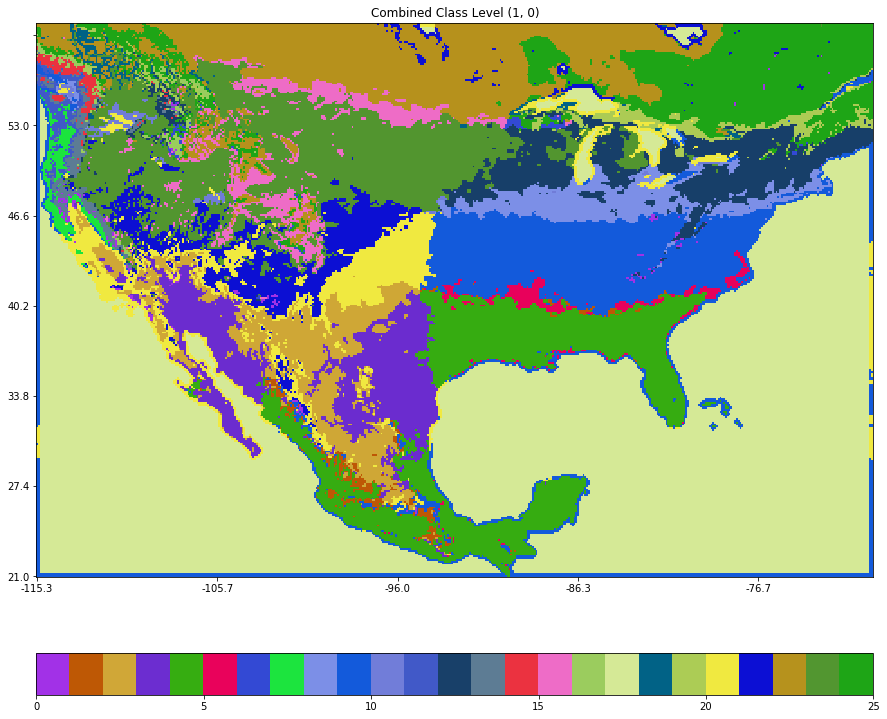

In [828]:
colormap = np.random.uniform(low=0,high=1,size = (25,3))
cmap = color.ListedColormap(colormap)


f, ax = plt.subplots(figsize=(15, 20), ncols=1, nrows=1)
    #Plot Prec
p0 = plt.imshow(labels_all[0], cmap=cmap, origin = [0,0])
#p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
plt.colorbar(p0, ax=ax, orientation='horizontal',
             pad=0.07, fraction=0.05)
plt.clim(0, 25)
ax.set_title('Combined Class Level ' + str((1,0)))
    
ax.set_xticklabels(lon_space, minor=False)
ax.set_yticklabels(lat_space, minor=False)

plt.show()

In [949]:
np.save('Prec_class_sets_0_1_240', Prec_classes_all)

In [950]:
np.save('Tmax_class_sets_0_1_240', Tmax_classes_all)

In [951]:
np.save('Tmin_class_sets_0_1_240', Tmin_classes_all)

In [952]:
np.save('label_sets_0_1_240', labels_all)

In [916]:
np.save('nan_mask_slice', nan_mask_slice)